In [2]:
import numpy as np
import pandas as pd
import pymc as pm
import matplotlib.pyplot as plt
import seaborn as sns
import preliz as pz

plt.rcParams["figure.figsize"] = (15, 3)
plt.style.use('ggplot')
np.random.seed(1337)  # for consistency

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Exercise 1

In [3]:
y_obs = np.load('toilet_paper_data.npy')

In [4]:
mean = y_obs.mean()
std = y_obs.std()

In [5]:
with pm.Model() as model:
    lbd = pm.Normal('lbd', mu=mean, sigma=std)
    exp = pm.Exponential('exp', lam=1 / std)
    y = pm.Normal('y', mu=lbd, sigma=exp, observed=y_obs)
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lbd, exp]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


array([<Axes: title={'center': 'exp'}>, <Axes: title={'center': 'lbd'}>],
      dtype=object)

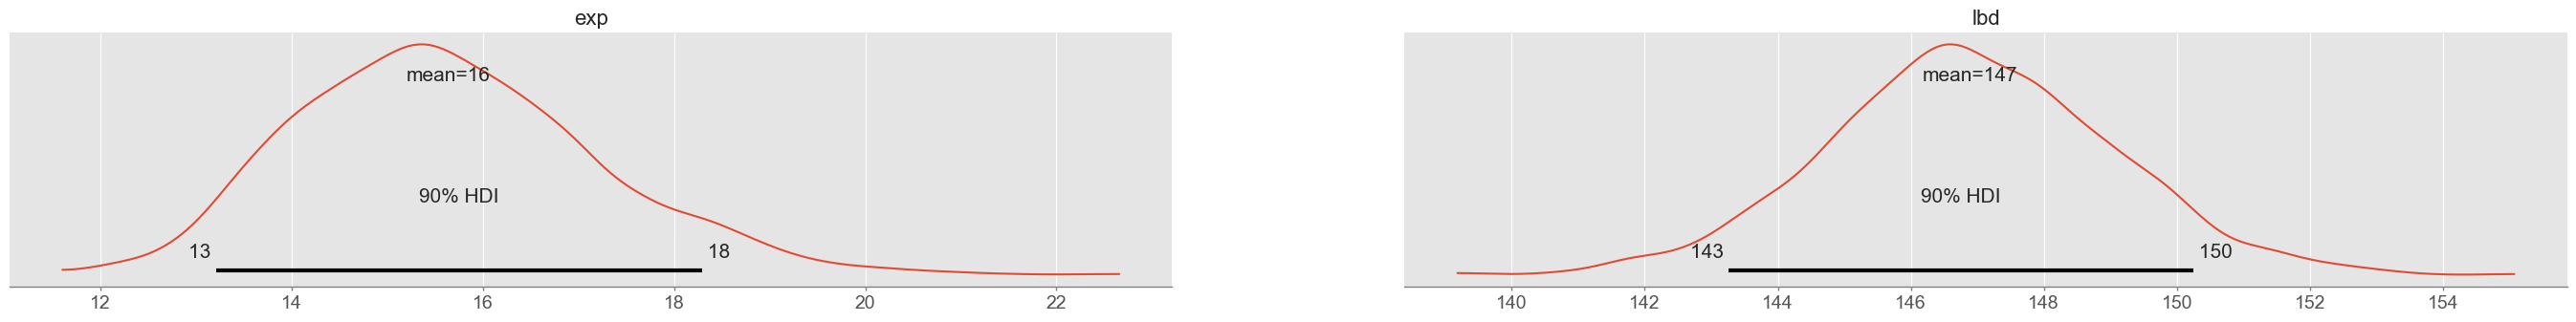

In [6]:
pm.plot_posterior(trace, hdi_prob=0.9)

In [7]:
pm.summary(trace, hdi_prob=0.9)

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
exp,15.633,1.574,13.213,18.291,0.025,0.017,4004.0,2746.0,1.0
lbd,146.883,2.149,143.265,150.248,0.035,0.025,3788.0,2831.0,1.0


array([[<Axes: >, None],
       [<Axes: xlabel='exp', ylabel='lbd'>, <Axes: >]], dtype=object)

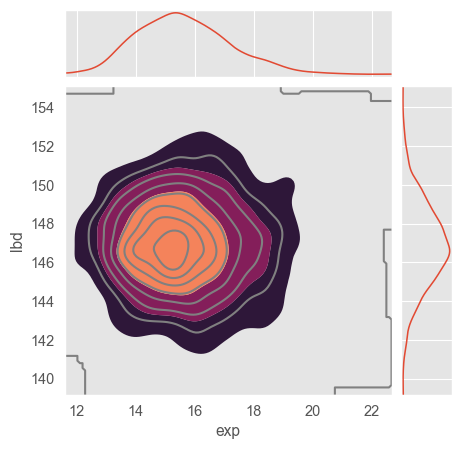

In [8]:
pm.plot_pair(trace, kind="kde", figsize=(5, 5), marginals=True)

In [9]:
data = np.hstack(
    [trace.posterior.lbd.values.flatten().reshape(-1, 1), trace.posterior.exp.values.flatten().reshape(-1, 1)])
np.cov(data.T)

array([[ 4.61851449, -0.02112012],
       [-0.02112012,  2.47816809]])

In [10]:
with model:
    pred = pm.sample_posterior_predictive(trace, var_names=['y'])

Sampling: [y]


Output()

In [11]:
ypred_normal = pred.posterior_predictive.y.values.reshape(-1, 53)
ypred_normal.shape

(4000, 53)

In [12]:
eps_normal = ypred_normal - y_obs
eps_normal

array([[ -2.32580124,  23.32608821,  25.07521341, ...,  11.67567831,
          4.0122109 ,   4.45990068],
       [ 11.3914968 ,  21.9178758 ,  -3.97462632, ...,  -1.29412123,
         11.17488249,   6.41193303],
       [-23.23737379,  13.1635492 ,   8.87083054, ...,   7.00498018,
         12.87711694,  20.07668259],
       ...,
       [-36.96534056,   4.27525262,   8.84590769, ...,  -1.1330003 ,
        -12.11174151,   0.11181367],
       [-27.20944542,  -7.81959813,  22.73306542, ...,  -8.86108124,
         -1.63916785,  25.88099788],
       [-25.00215935,  11.07855465,   4.13952703, ...,  11.5814818 ,
         -3.81387802,  12.20378974]])

In [13]:
rmse_in_kg = np.sqrt(np.mean(eps_normal ** 2))
print(f'RMSE in kg: {rmse_in_kg:.2f}')

RMSE in kg: 22.00


In [14]:
mae_in_kg = np.mean(np.abs(eps_normal))
print(f'MAE in kg: {mae_in_kg:.2f}')

MAE in kg: 16.78


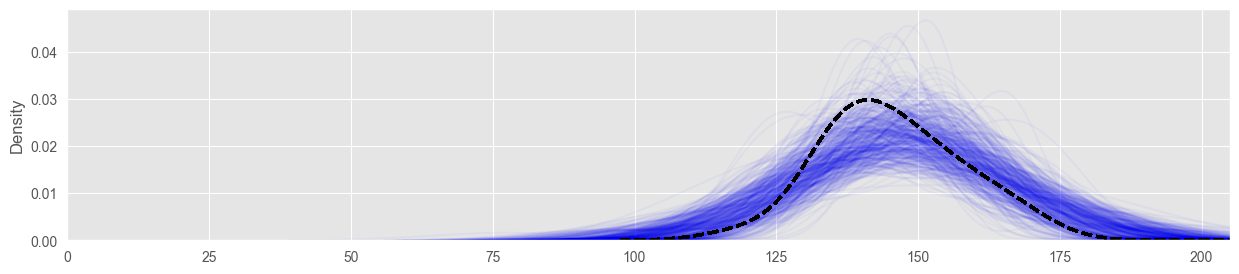

In [15]:
def ppc_plot(ppc, num_pp_samples=100):
    preds = ppc.posterior_predictive.y.values.reshape(-1, 20)
    samples = np.random.randint(preds.shape[0], size=num_pp_samples)
    for i in range(num_pp_samples):
        sns.kdeplot(preds[samples[i], :], c="blue", alpha=0.03)
        sns.kdeplot(ppc.observed_data.y, c="black", ls="--", lw=2, label="data")
        plt.xlim(0, np.max(preds[samples, :]))


ppc_plot(pred, num_pp_samples=500)

<Axes: xlabel='y'>

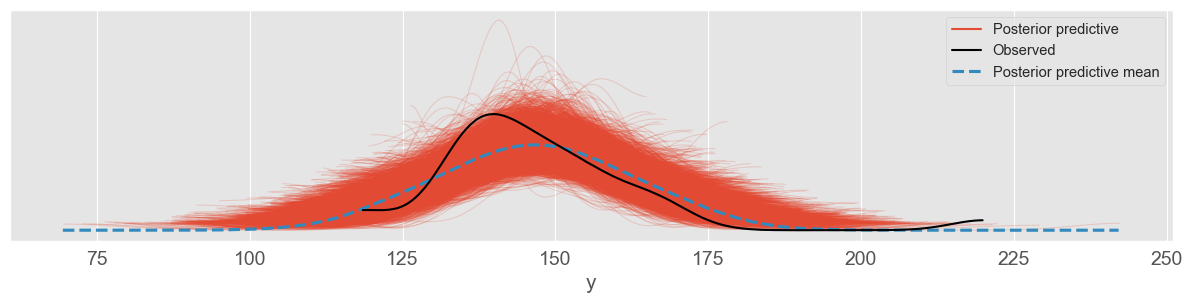

In [16]:
pm.plot_ppc(pred)

<Axes: >

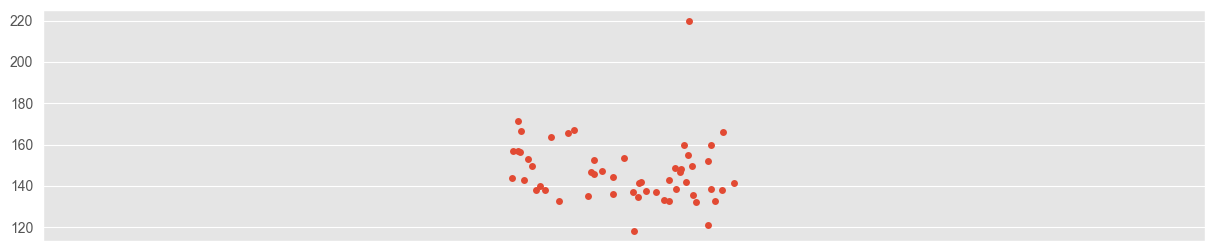

In [17]:
sns.stripplot(y_obs)

### Exercise 2

(-4.0, 4.0)

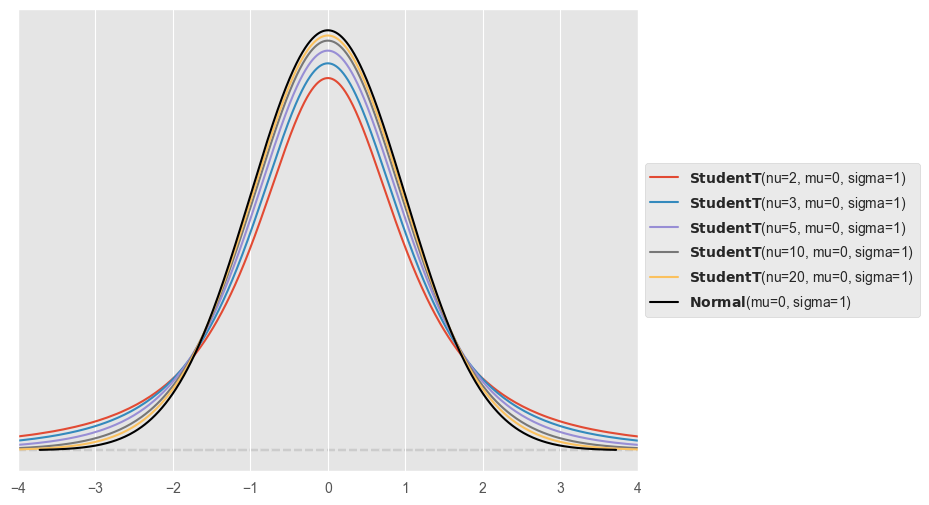

In [18]:
plt.figure(figsize=(8, 6))
for nu in [2, 3, 5, 10, 20]:
    pz.StudentT(mu=0, sigma=1, nu=nu).plot_pdf()
pz.Normal(mu=0, sigma=1).plot_pdf(color="black")
plt.xlim([-4, 4])

<Axes: >

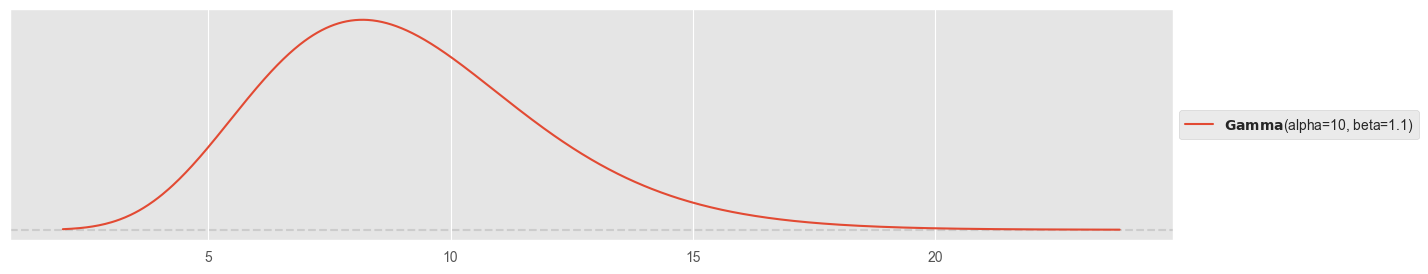

In [19]:
pz.Gamma(10, 1.1).plot_pdf()

In [20]:
with pm.Model() as model_student:
    μ = pm.Normal('μ', mu=mean, sigma=std)
    σ = pm.Exponential('σ', lam=1 / std)
    v = pm.Gamma('v', alpha=10, beta=1.1)
    y = pm.StudentT('y', mu=μ, sigma=σ, nu=v, observed=y_obs)
    trace_student = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ, v]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


array([<Axes: title={'center': 'v'}>, <Axes: title={'center': 'μ'}>,
       <Axes: title={'center': 'σ'}>], dtype=object)

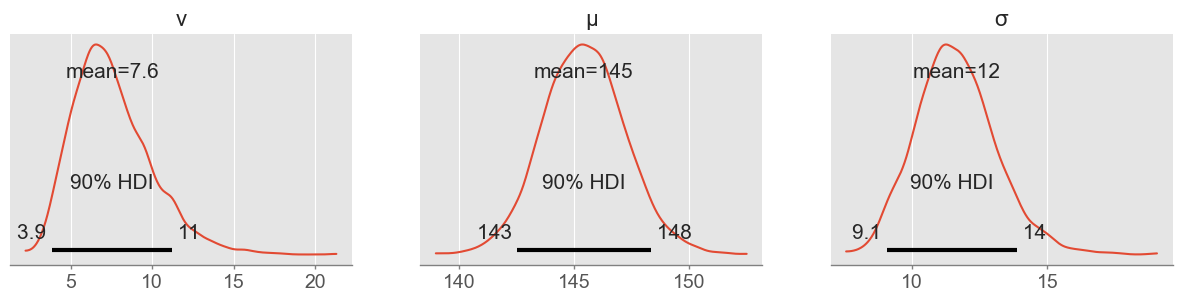

In [21]:
pm.plot_posterior(trace_student, figsize=(15, 3), hdi_prob=0.9)

In [22]:
with model_student:
    pred_stud = pm.sample_posterior_predictive(trace_student)

Sampling: [y]


Output()

Text(0.5, 1.0, "Student's t likelihood")

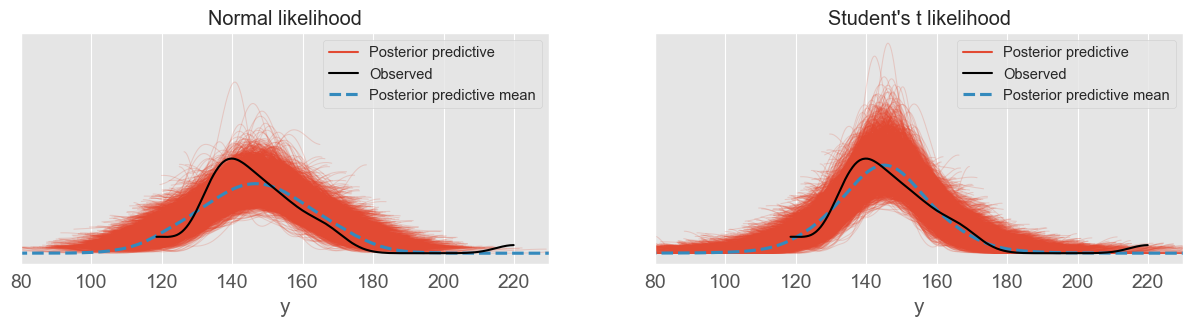

In [23]:
fig, ax = plt.subplots(1, 2, sharey=True)
plt.sca(ax[0])
pm.plot_ppc(pred, ax=ax[0])
plt.xlim(80, 230)
plt.title("Normal likelihood")
plt.sca(ax[1])
pm.plot_ppc(pred_stud, ax=ax[1])
plt.xlim(80, 230)
plt.title("Student's t likelihood")

In [24]:
ypred_normal = pred_stud.posterior_predictive.y.values.reshape(-1, 53)
ypred_normal.shape

(4000, 53)

In [25]:
eps_normal = ypred_normal - y_obs
eps_normal

array([[-31.96941384,   7.73776223,  -1.43914456, ..., -17.78170366,
        -13.80385941,  13.60487538],
       [-22.47753262,  11.19437646, -10.84102134, ...,  -7.27875874,
         -7.31229532,  14.70754657],
       [-22.25757621,   5.18631492,  -3.08530494, ...,   1.73381095,
         20.58166583,  16.8553643 ],
       ...,
       [  0.19229972,   3.91967643,   4.09109113, ...,  -7.29519946,
         -6.18348864,  16.61486418],
       [-60.92181405,  -1.32919793,  -5.18208756, ...,   7.09397268,
        -20.92564406,   0.29958027],
       [-37.76936634, -20.50269256,  12.46383102, ...,   0.91360007,
          5.91713785,  -1.42797419]])

In [26]:
rmse_in_kg = np.sqrt(np.mean(eps_normal ** 2))
print(f'RMSE in kg: {rmse_in_kg:.2f}')

RMSE in kg: 20.86


In [27]:
mae_in_kg = np.mean(np.abs(eps_normal))
print(f'MAE in kg: {mae_in_kg:.2f}')

MAE in kg: 15.42


In [28]:
with model:
    pm.compute_log_likelihood(trace)
loo1 = pm.loo(trace)

Output()

/Users/davebrunner/.local/share/virtualenvs/TSM_BayMachLe-lxpApnjz/lib/python3.12/site-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


In [29]:
with model_student:
    pm.compute_log_likelihood(trace_student)
loo2 = pm.loo(trace_student)

Output()

In [30]:
df_comp_loo = pm.compare({'Normal Likelihood': loo1, 'StudentT Likelihood': loo2})
df_comp_loo

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
StudentT Likelihood,0,-216.154391,2.793864,0.000000,1.0,9.017394,0.000000,False,log
Normal Likelihood,1,-224.312329,5.843558,8.157938,0.0,14.118584,6.223825,True,log


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

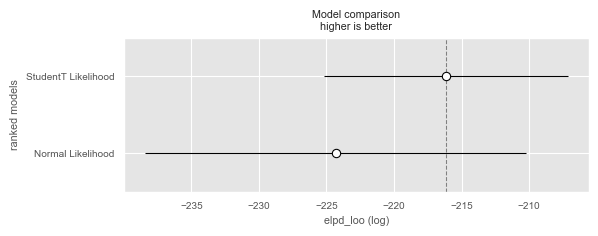

In [31]:
pm.plot_compare(df_comp_loo)

### Exercise 3

In [32]:
data = np.load('railway_switch_data.npy')

In [33]:
with pm.Model() as poission_model:
    λ = pm.Normal('λ', mu=data.mean(), sigma=data.std())
    y = pm.Poisson('y', mu=λ, observed=data)
    trace_poisson = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [λ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [34]:
with pm.Model() as neg_bin_model:
    λ = pm.Normal('λ', mu=data.mean(), sigma=data.std())
    σ = pm.Gamma('σ', alpha=2, beta=1)
    y = pm.NegativeBinomial('y', mu=λ, alpha=σ, observed=data)
    trace_neg_bin = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [λ, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


<Axes: >

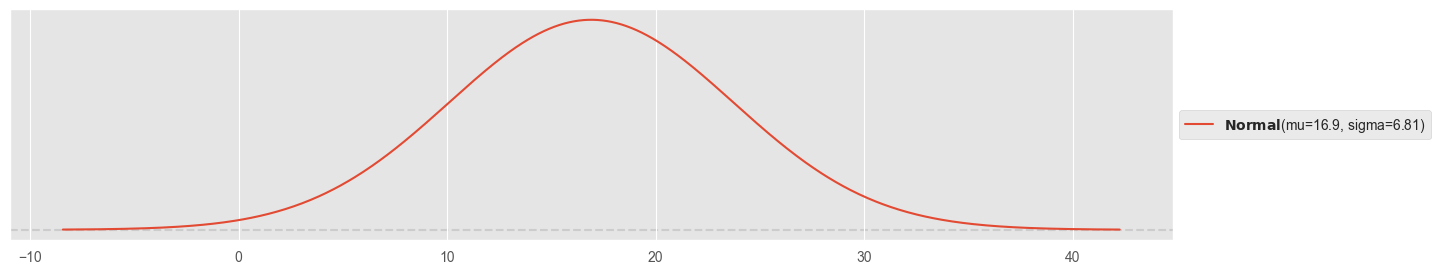

In [35]:
pz.Normal(mu=data.mean(), sigma=data.std()).plot_pdf()

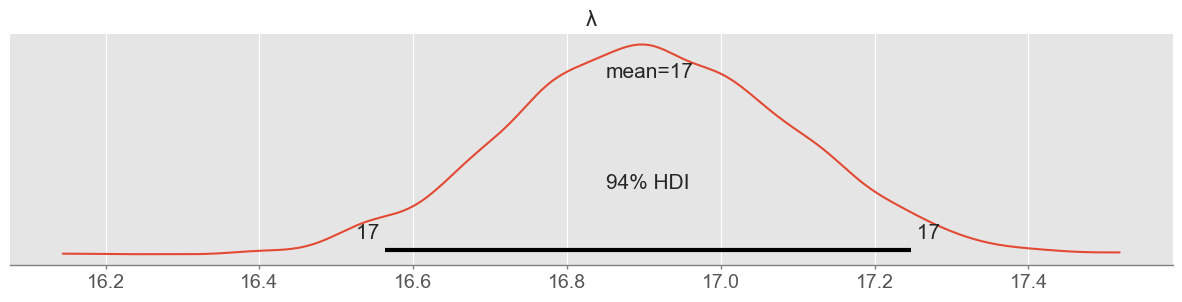

In [36]:
with poission_model:
    pm.plot_posterior(trace_poisson)

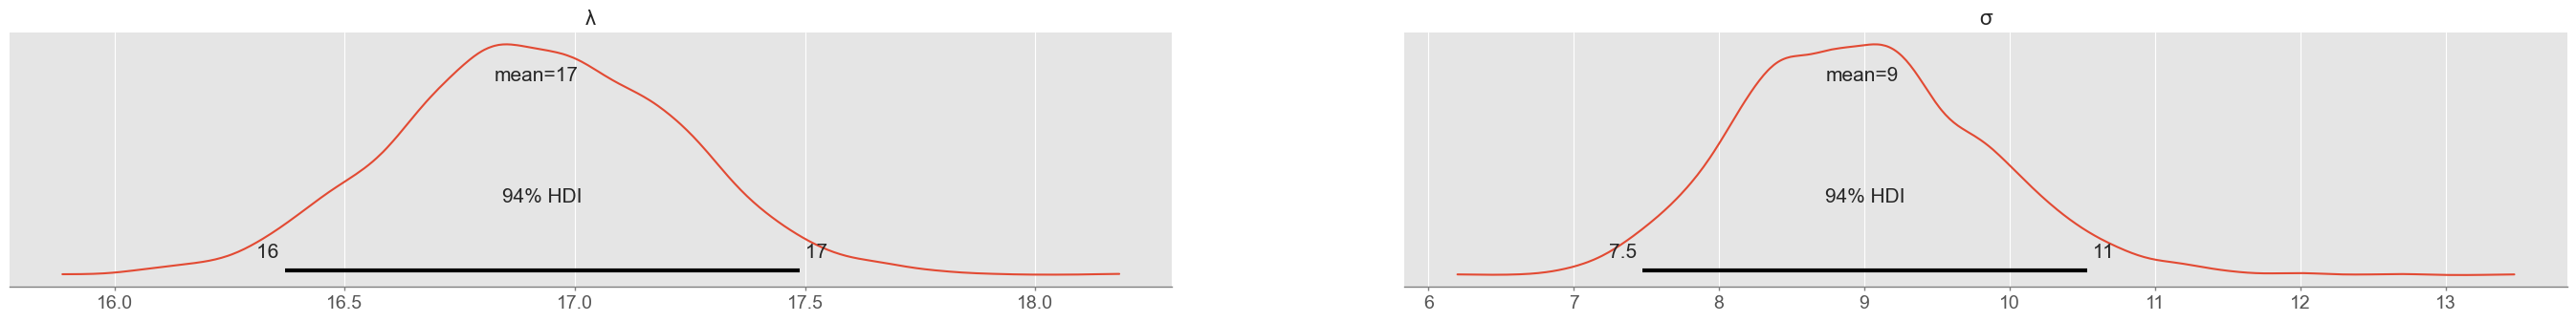

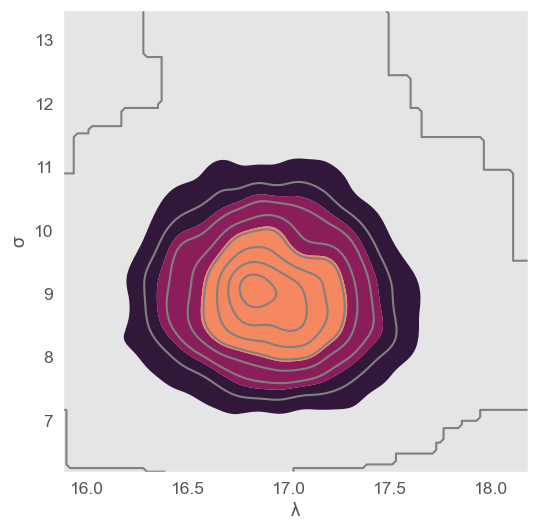

In [37]:
with neg_bin_model:
    pm.plot_posterior(trace_neg_bin)
    pm.plot_pair(trace_neg_bin, kind="kde", figsize=(6, 6))


In [38]:
with poission_model:
    pred_poisson = pm.sample_posterior_predictive(trace_poisson)
with neg_bin_model:
    pred_neg_bin = pm.sample_posterior_predictive(trace_neg_bin)


Sampling: [y]


Output()

Sampling: [y]


Output()

Text(0.5, 1.0, 'Negative binomial likelihood')

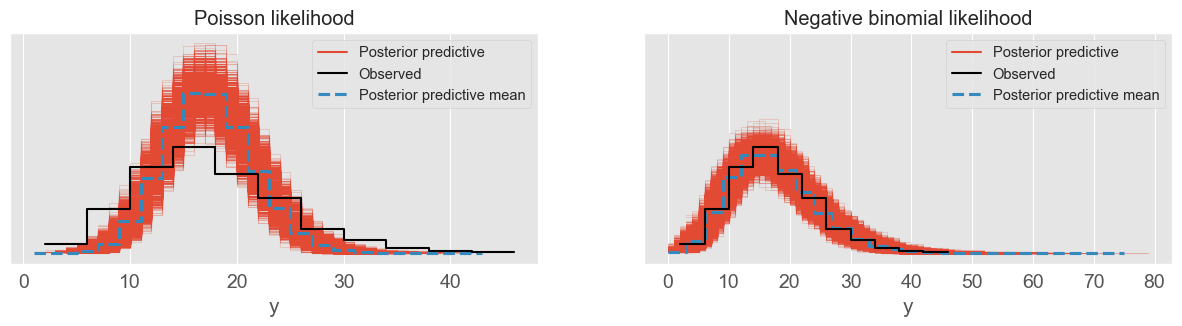

In [39]:
fig, ax = plt.subplots(1, 2, sharey=True)
plt.sca(ax[0])
pm.plot_ppc(pred_poisson, ax=ax[0])
plt.title("Poisson likelihood")
plt.sca(ax[1])
pm.plot_ppc(pred_neg_bin, ax=ax[1])
plt.title("Negative binomial likelihood")

In [40]:
with poission_model:
    pm.compute_log_likelihood(trace_poisson)
loo_poisson = pm.loo(trace_poisson)
with neg_bin_model:
    pm.compute_log_likelihood(trace_neg_bin)
loo_neg_bin = pm.loo(trace_neg_bin)

Output()

Output()

In [41]:
df_comp_loo = pm.compare({'Poisson Likelihood': loo_poisson, 'Negative Binomial Likelihood': loo_neg_bin})
df_comp_loo

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Negative Binomial Likelihood,0,-1753.639662,1.848064,0.000000,0.947519,16.076884,0.000000,False,log
Poisson Likelihood,1,-1944.914661,2.851545,191.274999,0.052481,44.246846,28.928466,False,log


In [42]:
ypred_poisson = pred_poisson.posterior_predictive.y.values.reshape(-1, 530)
ypred_negbin = pred_neg_bin.posterior_predictive.y.values.reshape(-1, 530)
eps_poisson = ypred_negbin - data
eps_neg_bin = ypred_poisson - data

In [43]:
rmse_poisson = np.sqrt(np.mean(eps_poisson ** 2))
rmse_neg_bin = np.sqrt(np.mean(eps_neg_bin ** 2))
print(f'RMSE Poisson: {rmse_poisson:.2f}')
print(f'RMSE Negative Binomial: {rmse_neg_bin:.2f}')

RMSE Poisson: 9.78
RMSE Negative Binomial: 7.96


In [44]:
mae_poisson = np.mean(np.abs(eps_normal))
mae_neg_bin = np.mean(np.abs(eps_neg_bin))
print(f'MAE Poisson: {mae_poisson:.2f}')
print(f'MAE Negative Binomial: {mae_neg_bin:.2f}')

MAE Poisson: 15.42
MAE Negative Binomial: 6.29


### Exercise 4

In [45]:
k1 = 82
k2 = 24
k3 = 6
data = [k1, k2, k3]

<Axes: title={'center': '$\\bf{Dirichlet}$(alpha=[2. 1. 1.])'}>

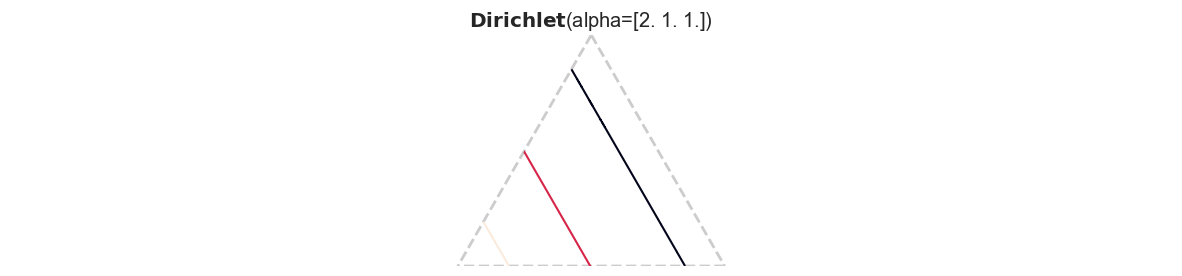

In [46]:
pz.Dirichlet(alpha=[2, 1, 1]).plot_pdf(marginals=False)

In [47]:
with pm.Model() as insurance:
    pi = pm.Dirichlet('pi', a=[1, 1, 1])
    y_new = pm.Multinomial('y_new', n=112, p=pi, observed=[82, 24, 6])
    insurance_trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pi]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


array([<Axes: title={'center': 'pi\n0'}>,
       <Axes: title={'center': 'pi\n1'}>,
       <Axes: title={'center': 'pi\n2'}>], dtype=object)

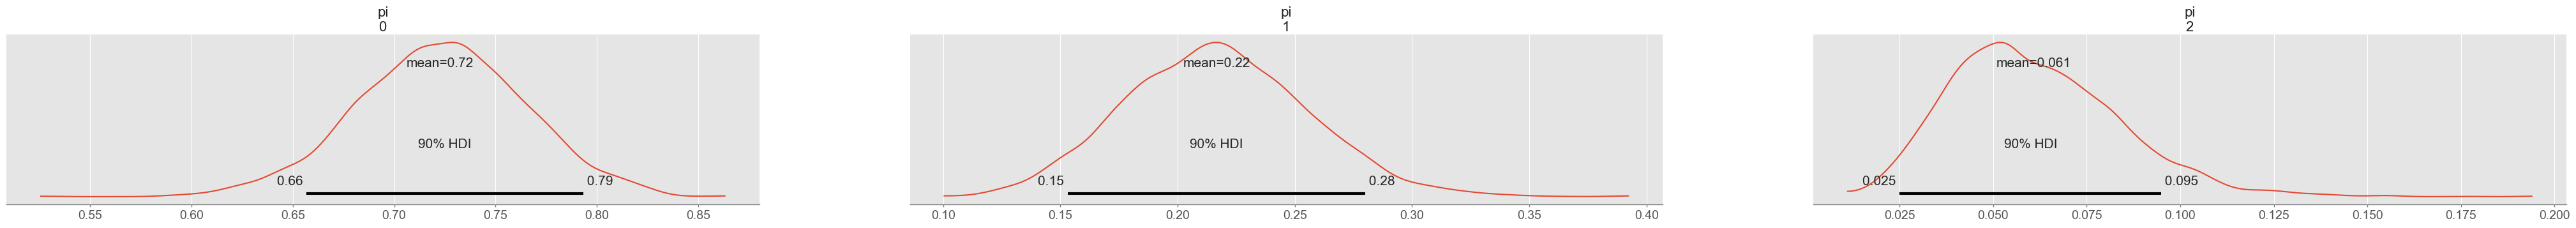

In [48]:
pm.plot_posterior(insurance_trace, hdi_prob=0.9)

<Axes: title={'center': '$\\bf{Dirichlet}$(alpha=[83. 25.  7.])'}>

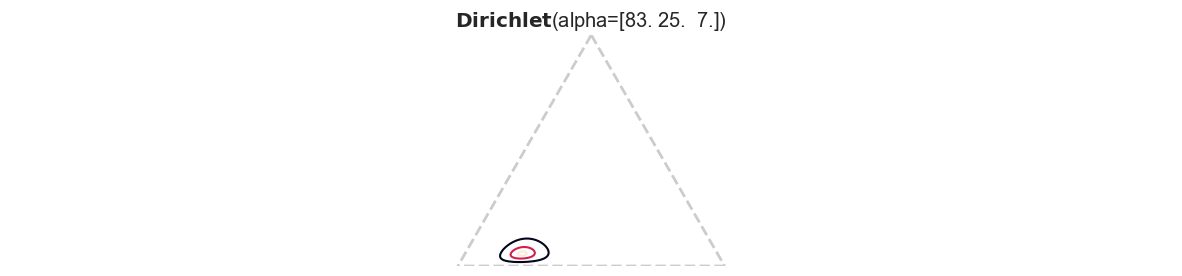

In [49]:
alpha2 = np.array([1, 1, 1]) + np.array(data)
pz.Dirichlet(alpha=alpha2).plot_pdf(marginals=False)

<Axes: title={'center': '$\\bf{Dirichlet}$(alpha=[92. 25.  7.])'}>

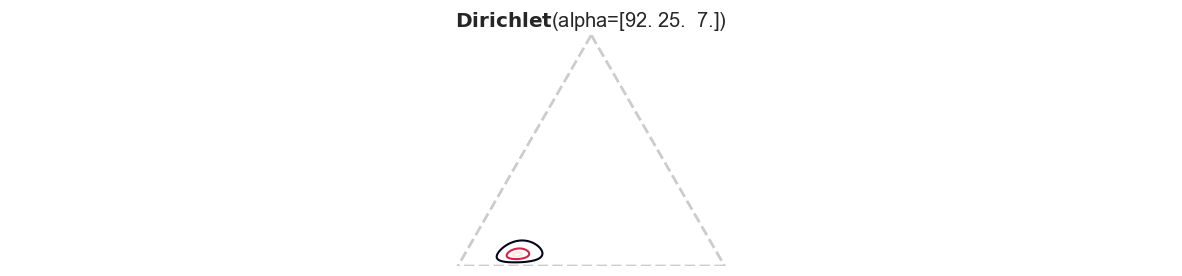

In [50]:
alpha2 = np.array([10, 1, 1]) + np.array(data)
pz.Dirichlet(alpha=alpha2).plot_pdf(marginals=False)

In [51]:
pz.Dirichlet(alpha=data).summary()

Dirichlet(mean=array([0.73214286, 0.21428571, 0.05357143]), std=array([0.04165914, 0.03860021, 0.02118221]))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pi]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


array([<Axes: title={'center': 'pi\n0'}>,
       <Axes: title={'center': 'pi\n1'}>,
       <Axes: title={'center': 'pi\n2'}>], dtype=object)

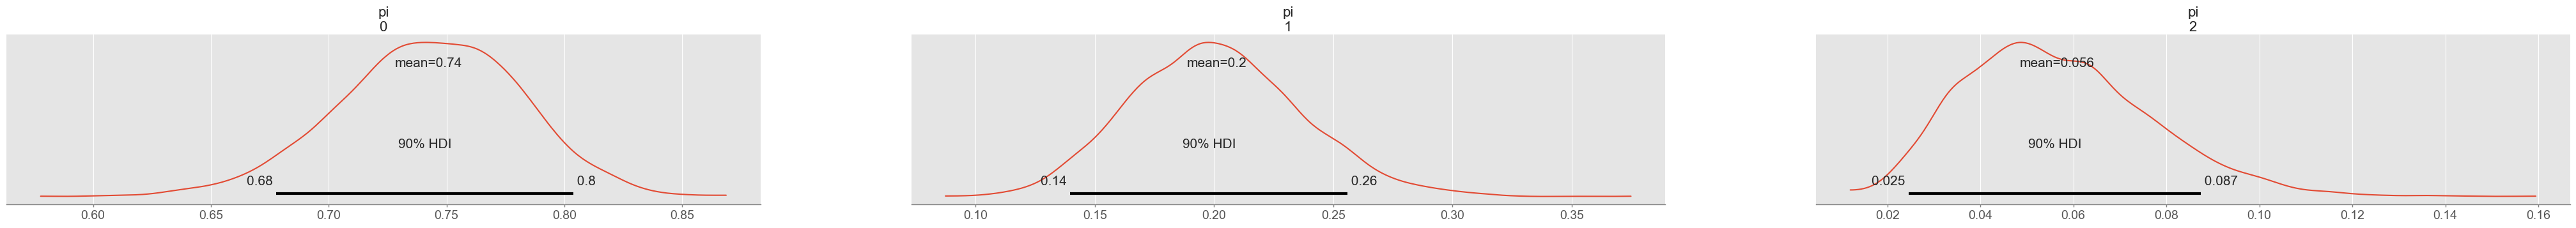

In [52]:
with pm.Model() as insurance:
    pi = pm.Dirichlet('pi', a=[10, 1, 1])
    y_new = pm.Multinomial('y_new', n=112, p=pi, observed=[82, 24, 6])
    insurance_trace = pm.sample(1000)
pm.plot_posterior(insurance_trace, hdi_prob=0.9)

### Exercise 5

In [53]:
credit_data = pd.read_csv("credit_data.csv")
credit_data.head()

,ID,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
0,1,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
1,2,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
2,3,104.593,7075,514,4,71,11,Male,No,No,Asian,580
3,4,148.924,9504,681,3,36,11,Female,No,No,Asian,964
4,5,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331


In [54]:
credit_data = credit_data[['Income', 'Rating']]
credit_mean = credit_data.mean()
credit_std = credit_data.std()
print(f'Mean: {credit_mean} \n Std: {credit_std}')

Mean: Income     45.218885
Rating    354.940000
dtype: float64 
 Std: Income     35.244273
Rating    154.724143
dtype: float64


In [55]:
credit_data_scaled = (credit_data - credit_data.mean()) / credit_data.std()

In [56]:
with pm.Model() as mv_normal_model:
    # Prior for the mean (should be around zero!) - assume a lot of (symmetric) covariance
    mean = pm.MvNormal('mean', mu=0, cov=[[1, 0], [0, 1]])
    # Prior for standard deviations (to rescale the correlation matrix to the covariance matrix)
    sigma_dist = pm.Exponential.dist(1)
    # Prior for the correlation matrix (flat for eta=1, estimating cov through Cholesky decomposition)
    chol, corr, sigmas = pm.LKJCholeskyCov('chol_cov', eta=1, n=2, sd_dist=sigma_dist)
    cov = chol.dot(chol.T)
    COV = pm.Deterministic('cov', cov)  # store as variable for later access
    # Define the multivariate normal distribution
    y_pred = pm.MvNormal('y_pred', mu=mean, cov=cov, observed=credit_data[['Income', 'Rating']].values)
    # Perform Bayesian inference
    # (warm-up phase reduced to 1000 steps, increase the target _accept rate for nuts for better stability)
    trace = pm.sample(draws=2000, chains=4, tune=1000, nuts={'target_accept': 0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mean, chol_cov]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 8 seconds.


array([[<Axes: title={'center': 'mean'}>,
        <Axes: title={'center': 'mean'}>],
       [<Axes: title={'center': 'cov'}>, <Axes: title={'center': 'cov'}>]],
      dtype=object)

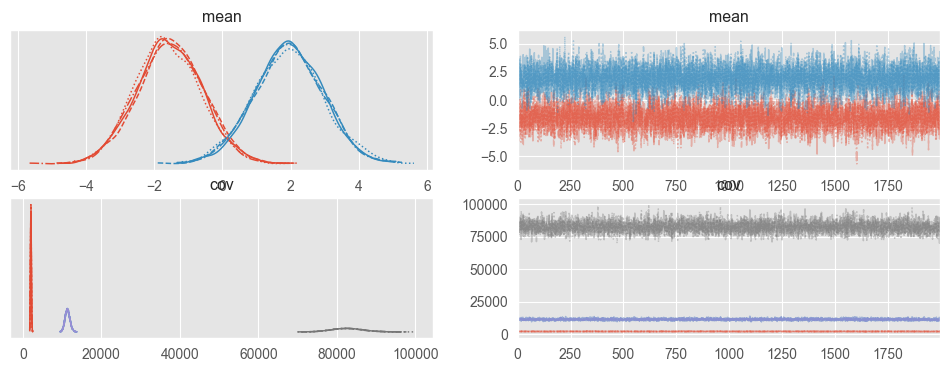

In [57]:
pm.plot_trace(trace, var_names=["mean", "cov"])

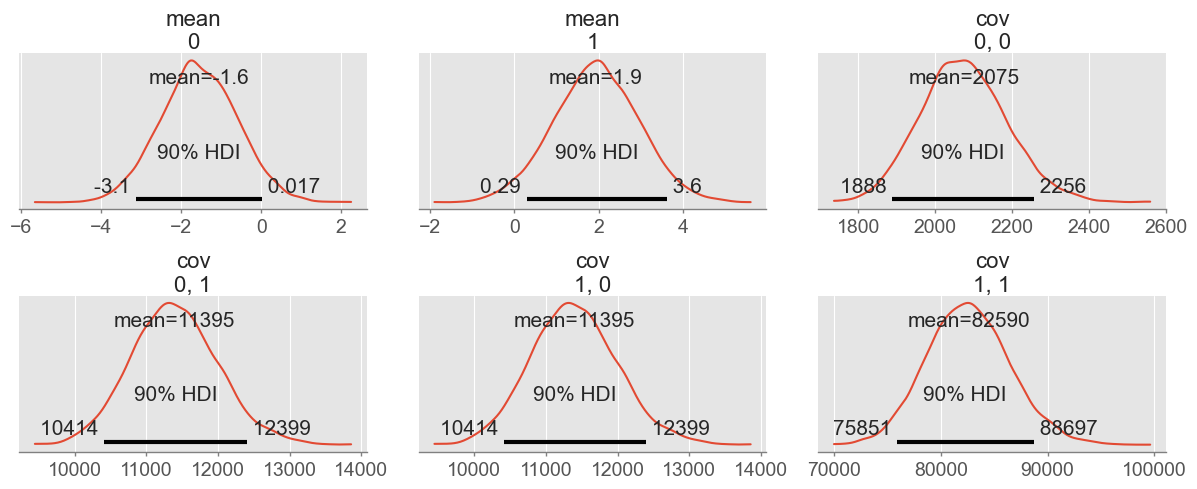

In [58]:
pm.plot_posterior(trace, var_names=["mean", "cov"], figsize=(12, 5), hdi_prob=0.9)
plt.tight_layout()

In [ ]:
with mv_normal_model:
    pred = pm.sample_posterior_predictive(trace)

Sampling: [y_pred]


Output()

In [ ]:
pm.plot_ppc(pred)

In [ ]:
samples = pred.posterior_predictive.y_pred.values.reshape(-1, 2)
samples.shape

In [ ]:
inds = np.random.choice(np.arange(samples.shape[0]), 4000)
samples = samples[inds, :]
samples.shape

Rescale samples back to original mean + standard deviation:

In [ ]:
samples = samples * credit_std.values + credit_mean.values


In [ ]:
# Scatter plot:
plt.scatter(samples[:, 0], samples[:, 1], label="simulation")
plt.scatter(credit_data.Income, credit_data.Rating, c="black", label="data")
plt.legend()
